In [4]:
import requests
import zipfile
import io
import os
import yaml
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import time
warnings.filterwarnings('ignore')

def generate_data(yamlFile):
    '''
    generate data and return csv names
    '''
    
    url = "http://oasis.caiso.com/oasisapi/SingleZip"
    extract_directory = ""
    csv_list = []
    start_time = yamlFile["start_time"]
    end_time = yamlFile["end_time"]
    forecast_type = yamlFile["forecast_type"]
    market_run_id = yamlFile["market_run_id"]
    execution_type = yamlFile["execution_type"]
    csv_name = f"{start_time}_{end_time}_{forecast_type}_{market_run_id}_{execution_type}.csv"
    csv_name = os.path.join("data", csv_name)
    start_time = datetime.strptime(start_time, "%Y%m%dT%H:%M%z")
    end_time = datetime.strptime(end_time, "%Y%m%dT%H:%M%z")
    merged_data = pd.DataFrame()

    if  not os.path.exists(csv_name):
        while end_time > start_time:
            def request(start_time, end_time):
                params = {
                    "resultformat": "6",
                    "queryname": forecast_type,
                    "market_run_id": market_run_id,
                    "execution_type": execution_type,
                    "version": "1",
                    "startdatetime": start_time.strftime('%Y%m%dT%H:%M%z').replace("+","-"),
                    "enddatetime": min(start_time + timedelta(days=30), end_time).strftime('%Y%m%dT%H:%M%z').replace("+","-")
                }

                response = requests.get(url, params=params)
                while response.status_code == 429:
                    time.sleep(1)
                    response = request(start_time, end_time)
                return response

            response=request(start_time, end_time)
            if response.status_code == 200:
                data = response.content
                zip_data = io.BytesIO(data)
                csv = None
                with zipfile.ZipFile(zip_data, 'r') as zip_ref:
                    file_bytes = zip_ref.read(zip_ref.namelist()[0])
                    merged_data = pd.concat([merged_data, pd.read_csv(io.BytesIO(file_bytes))], ignore_index=True)
            else:
                print("Request failed with status code:", response.status_code)
            
            start_time += timedelta(days=30)
            time.sleep(1)
            
        merged_data.to_csv(csv_name, index=False)
    return csv_name

In [5]:
def split_data(csv, yamlFile):
  '''
  split data from one csv to specific dataset
  '''
  
  data = pd.read_csv(csv)

  # print(data.shape)

  zone_id = yamlFile["zone_id"]
  training_set_start = yamlFile["training_set_start"]
  training_set_end = yamlFile["training_set_end"]
  validation_set_start = yamlFile["validation_set_start"]
  validation_set_end = yamlFile["validation_set_end"]
  test_set_start = yamlFile["test_set_start"]
  test_set_end = yamlFile["test_set_end"]
  TAC_AREA_NAME = yamlFile["TAC_AREA_NAME"]
  training_set = data.query(f'OPR_DT <= "{training_set_end}" and OPR_DT >= "{training_set_start}" and TAC_AREA_NAME == "{TAC_AREA_NAME}"')
  validation_set = data.query(f'OPR_DT <= "{validation_set_end}" and OPR_DT >= "{validation_set_start}" and TAC_AREA_NAME == "{TAC_AREA_NAME}"')
  test_set = data.query(f'OPR_DT <= "{test_set_end}" and OPR_DT >= "{test_set_start}" and TAC_AREA_NAME == "{TAC_AREA_NAME}"')
  training_set.loc[:, 'training_type'] = 'training'
  validation_set.loc[:, 'training_type'] = 'validation'
  test_set.loc[:, 'training_type'] = 'test'
  
  return training_set, validation_set, test_set

In [6]:
def limit_display(num_ticks):
  """
  limit display number of x data points
  """
  ax = plt.gca()
  x_ticks = ax.get_xticks()
  x_labels = ax.get_xticklabels()
  step = len(x_ticks) // num_ticks
  ax.set_xticks(x_ticks[::step])
  ax.set_xticklabels(x_labels[::step])
  plt.show()
  


In [7]:
  
def visualization(yamlFile):
  ''' 
  visualize for certain data, generate one graph
  '''
  csv = generate_data(yamlFile)
  training_set, validation_set, test_set = split_data(csv, yamlFile)
  wholedata = pd.concat([training_set, validation_set])
  wholedata = wholedata.sort_values(by="INTERVALSTARTTIME_GMT")
  plot = sns.relplot(data=wholedata, x="INTERVALSTARTTIME_GMT", y="MW", hue="training_type", kind="line", height=4, aspect=4)
  label = yamlFile['market_run_id'] if not yamlFile['execution_type'] else yamlFile['market_run_id']+" - "+yamlFile['execution_type']
  plot.fig.suptitle(label)
  limit_display(5)
  # os.remove(csv)

In [8]:
def visualize_data():
  warnings.filterwarnings('ignore')
  with open("demand.yaml") as file:
    yamlFile = yaml.safe_load(file)

  visualize_id = yamlFile['visualize_id']
  for run_id in visualize_id:
    if not visualize_id[run_id]:
      yamlFile['market_run_id'] = run_id
      yamlFile['execution_type'] = None
      with open('demand.yaml', 'w') as conf:
        yaml.dump(yamlFile, conf)
      visualization(yamlFile)

    else:
      for exec_type in visualize_id[run_id]:
        yamlFile['market_run_id'] = run_id
        yamlFile['execution_type'] = exec_type
        with open('demand.yaml', 'w') as conf:
          yaml.dump(yamlFile, conf)
        visualization(yamlFile)

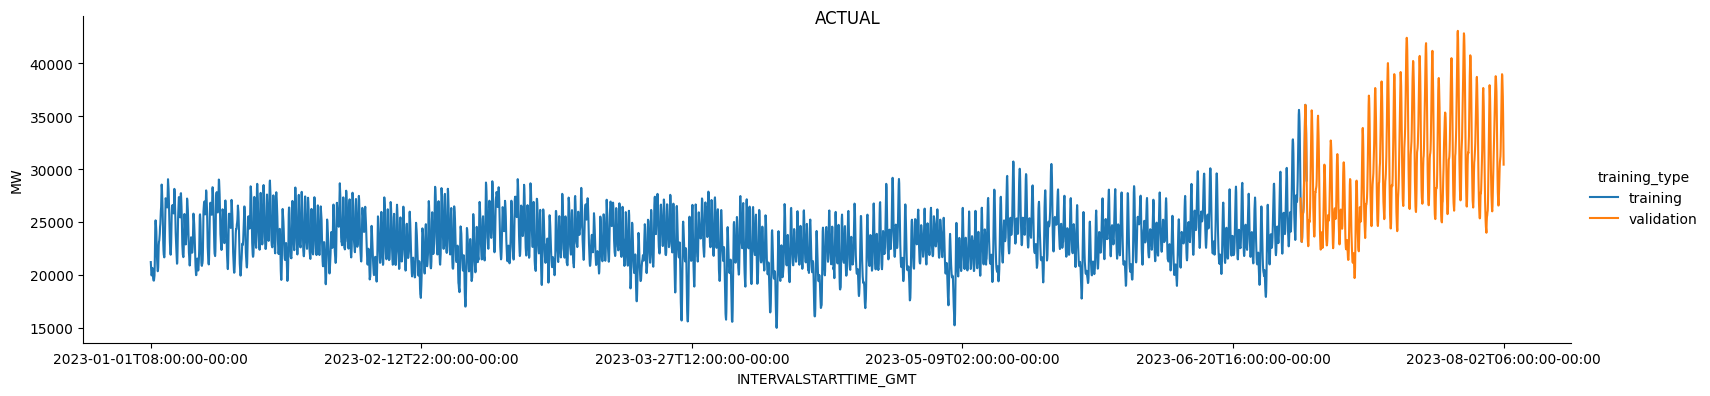

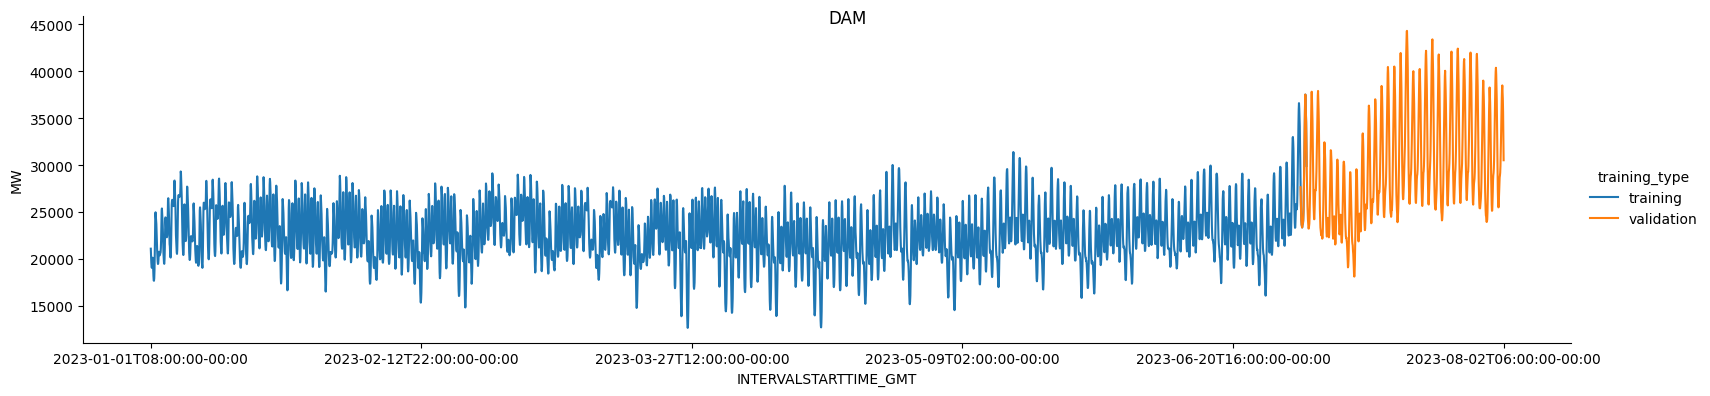

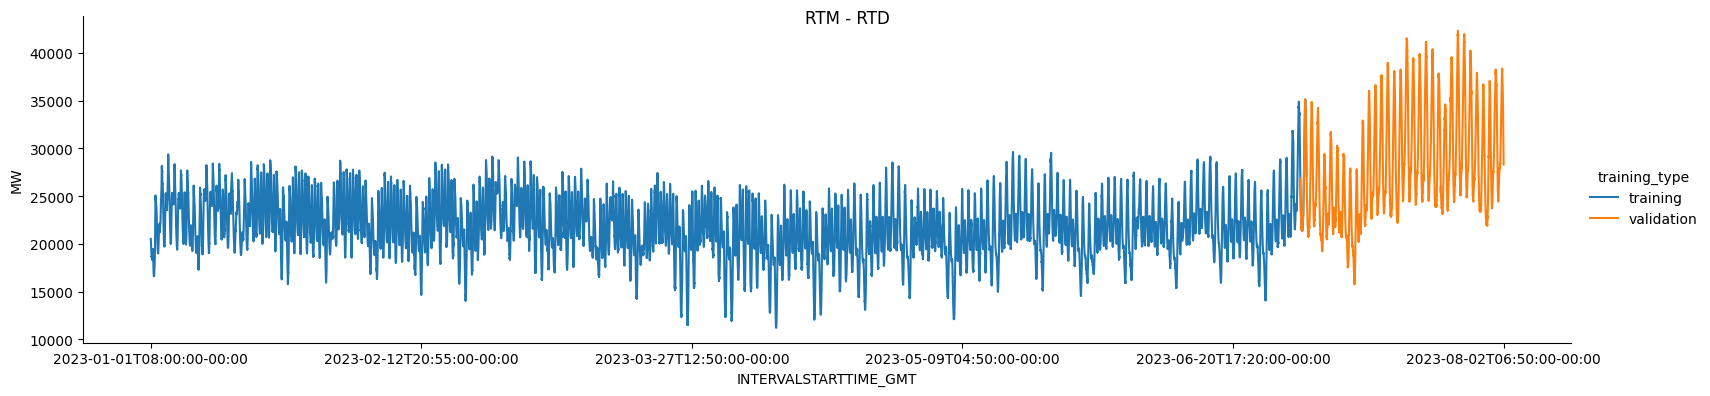

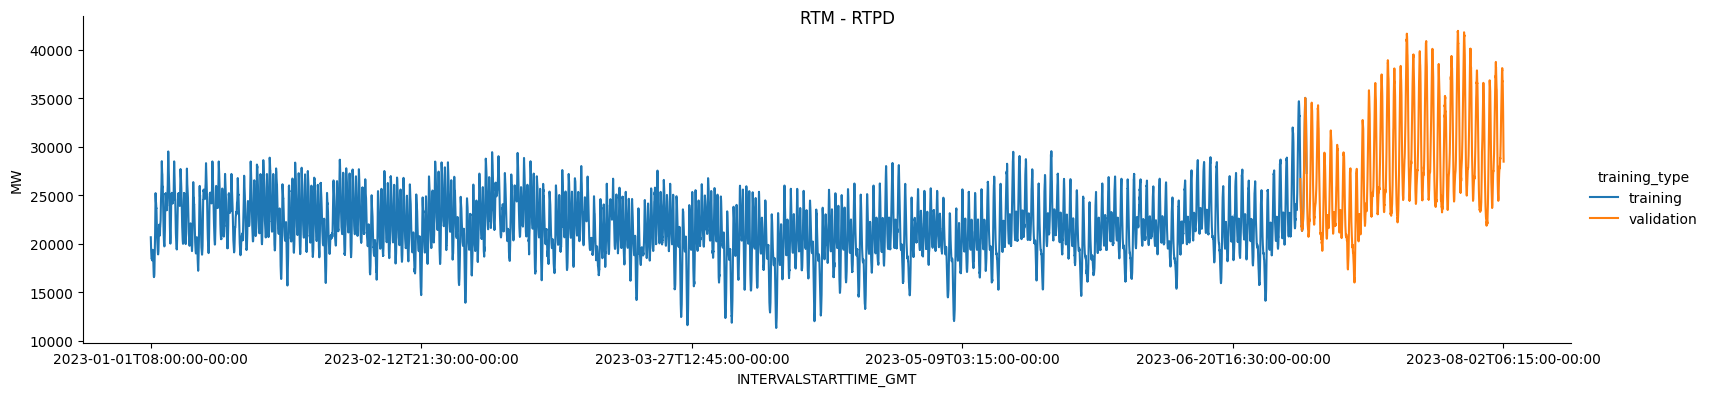

In [6]:
visualize_data()

In [7]:
def visulize_difference():
  with open("demand.yaml") as file:
    yamlFile = yaml.safe_load(file)

  minus_visualize_id = yamlFile['minus_visualize']
  for minus_list in minus_visualize_id:
    yamlFile['market_run_id'] = minus_list[0]
    yamlFile['execution_type'] = minus_list[1]
    with open('demand.yaml', 'w') as conf:
      yaml.dump(yamlFile, conf)
    csv = generate_data(yamlFile)
    training_set, validation_set, test_set = split_data(csv, yamlFile)
    wholedata1 = pd.concat([training_set, validation_set])
    # os.remove(csv)
    label1 = yamlFile['market_run_id'] if not yamlFile['execution_type'] else yamlFile['market_run_id']+" - "+yamlFile['execution_type']
    
    yamlFile['market_run_id'] = minus_list[2]
    yamlFile['execution_type'] = minus_list[3]
    with open('demand.yaml', 'w') as conf:
      yaml.dump(yamlFile, conf)
    csv = generate_data(yamlFile)
    training_set, validation_set, test_set = split_data(csv, yamlFile)
    wholedata2 = pd.concat([training_set, validation_set])
    # os.remove(csv)
    label2 = yamlFile['market_run_id'] if not yamlFile['execution_type'] else yamlFile['market_run_id']+" - "+yamlFile['execution_type']
    
    wholedata = pd.merge(wholedata1, wholedata2, on='INTERVALSTARTTIME_GMT', suffixes=('_1', '_2'))
    wholedata['MW_diff'] = wholedata['MW_1'] - wholedata['MW_2']
    plot = sns.relplot(data=wholedata, x="INTERVALSTARTTIME_GMT", y="MW_diff", hue="training_type_1", kind="line", height=4, aspect=4)
    plot.fig.suptitle(label1+" minus "+label2)
    limit_display(5)

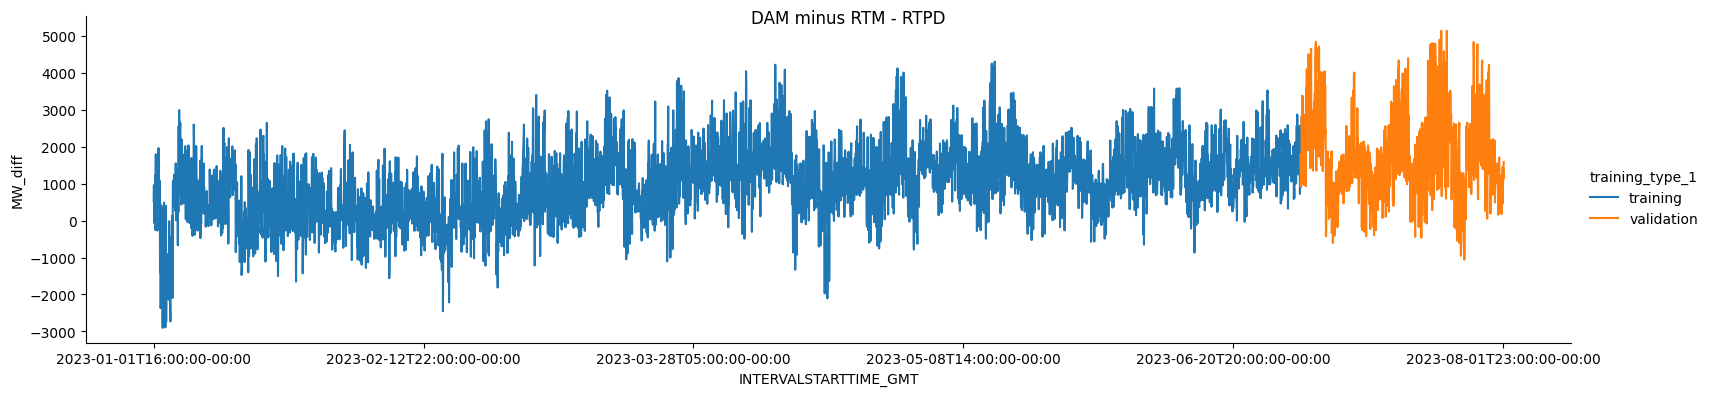

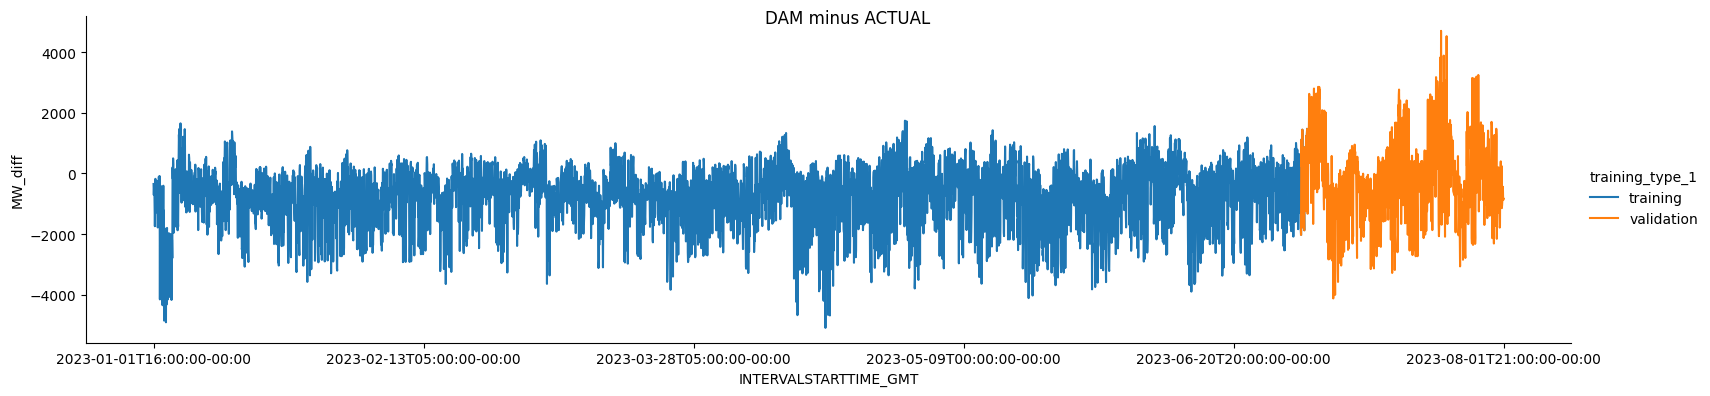

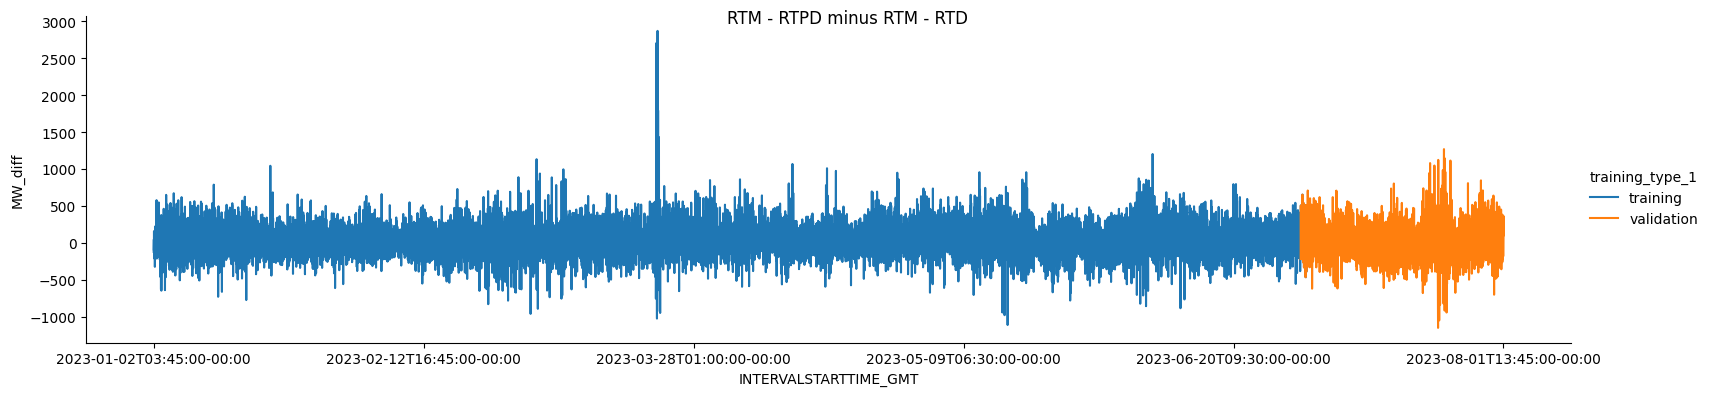

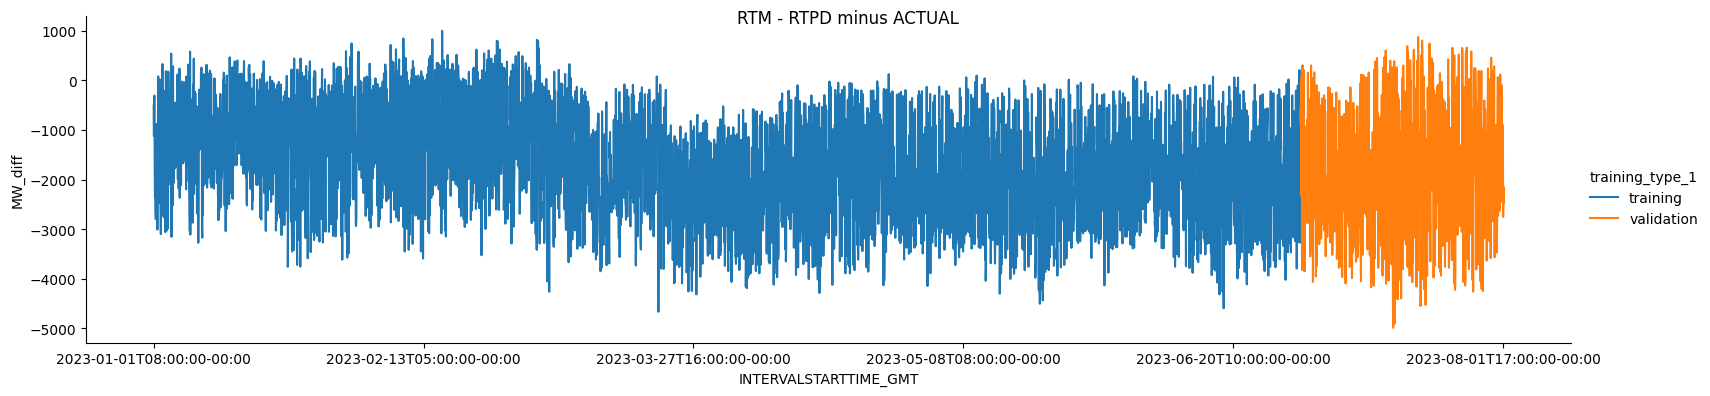

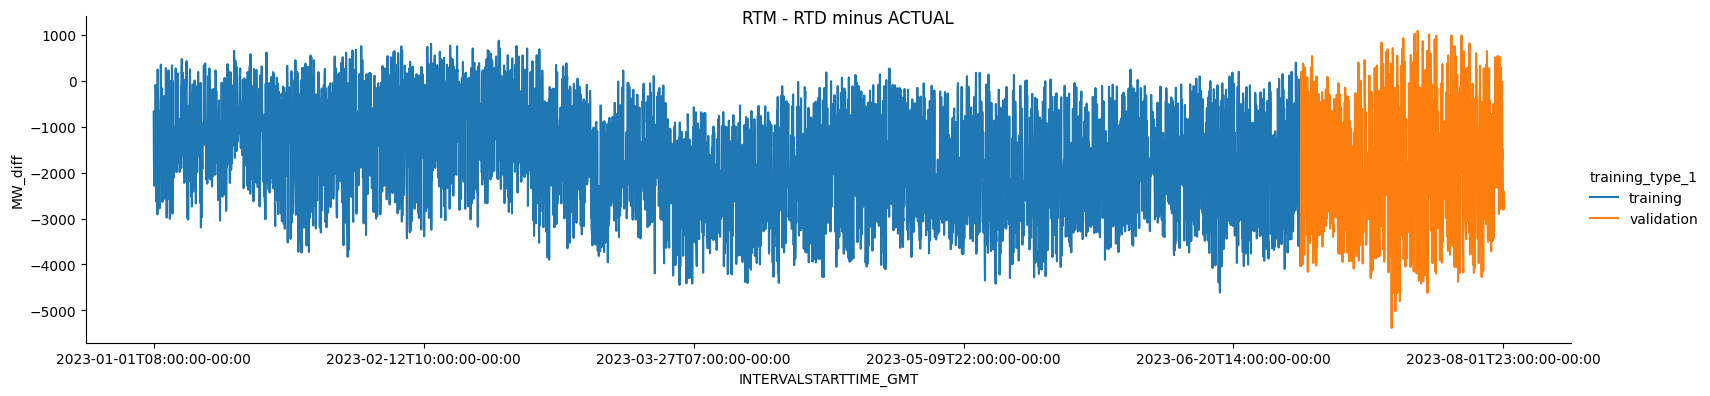

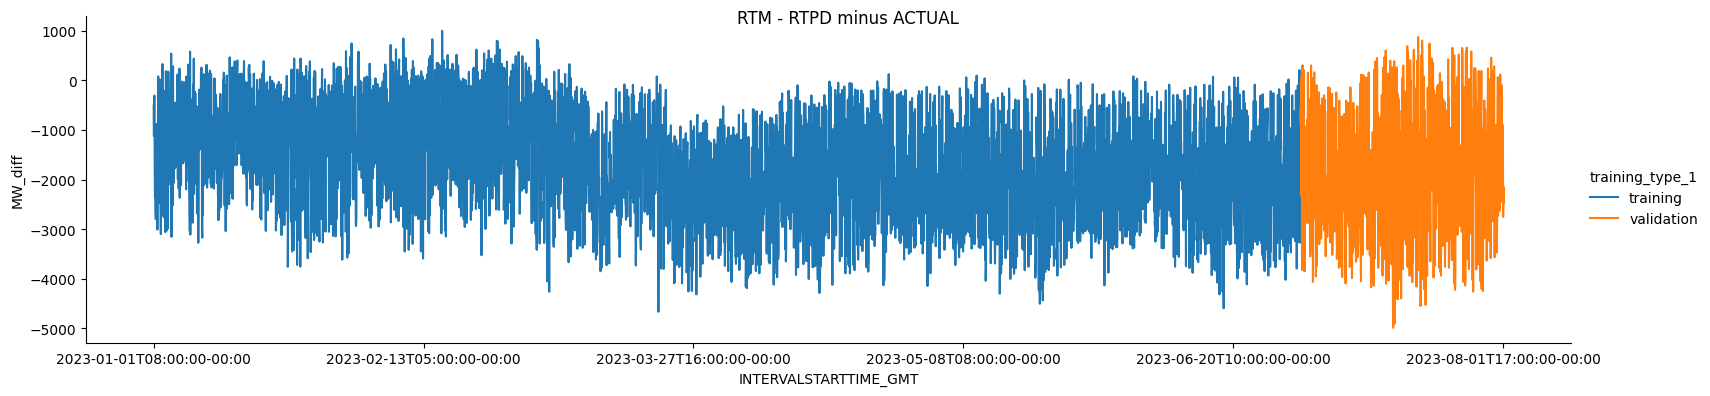

In [8]:
visulize_difference()

In [287]:
def CAISO_forecast():
  ''' 
  get the CAISO forecast data as training set, e.g. DAM
  '''
  with open("demand.yaml") as file:
    yamlFile = yaml.safe_load(file)
  with open('demand.yaml', 'w') as conf:
    yamlFile['market_run_id'] = "DAM"
    yamlFile['execution_type'] = None
    yaml.dump(yamlFile, conf)
    csv = generate_data(yamlFile)
  training_set, validation_set, test_set = split_data(csv, yamlFile)
  return np.array(training_set["INTERVALSTARTTIME_GMT"]), np.array(training_set["MW"]), np.array(validation_set["INTERVALSTARTTIME_GMT"]), np.array(validation_set["MW"]), np.array(test_set["INTERVALSTARTTIME_GMT"]), np.array(test_set["MW"])
  
def GodMode():
  ''' 
  get the actual data
  '''
  with open("demand.yaml") as file:
    yamlFile = yaml.safe_load(file)
  with open('demand.yaml', 'w') as conf:
    yamlFile['market_run_id'] = "ACTUAL"
    yamlFile['execution_type'] = None
    yaml.dump(yamlFile, conf)
    csv = generate_data(yamlFile)
  training_set, validation_set, test_set = split_data(csv, yamlFile)
  return np.array(training_set["INTERVALSTARTTIME_GMT"]), np.array(training_set["MW"]), np.array(validation_set["INTERVALSTARTTIME_GMT"]), np.array(validation_set["MW"]), np.array(test_set["INTERVALSTARTTIME_GMT"]), np.array(test_set["MW"])
  
def add_gaussian_noise(y, k):
  std = k * np.max(y)
  noise = np.random.normal(loc=0, scale=std, size=y.shape)
  noise = noise - np.mean(noise)
  y_noisy = y + noise
  return y_noisy

def add_beta_noise(y, k):
    std = k * np.max(y)
    alpha, beta = 1, 1
    noise = np.random.beta(alpha, beta, size=y.shape)
    ratio = std/np.std(noise)
    noise = noise*ratio
    noise = noise - np.mean(noise)
    y_noisy = y + noise
    return y_noisy
  
def add_weibull_noise(y, k):
  std = k * np.max(y)
  noise = np.random.weibull(2, size=y.shape)
  ratio = std/np.std(noise)
  noise = noise*ratio
  noise = noise - np.mean(noise)
  y_noisy = y + noise

  return y_noisy
      
def add_laplace_noise(y, k):
    std = k * np.max(y)
    noise = np.random.laplace(scale=std, size=y.shape)
    ratio = std/np.std(noise)
    noise = noise*ratio
    noise = noise - np.mean(noise)
    y_noisy = y + noise

    return y_noisy

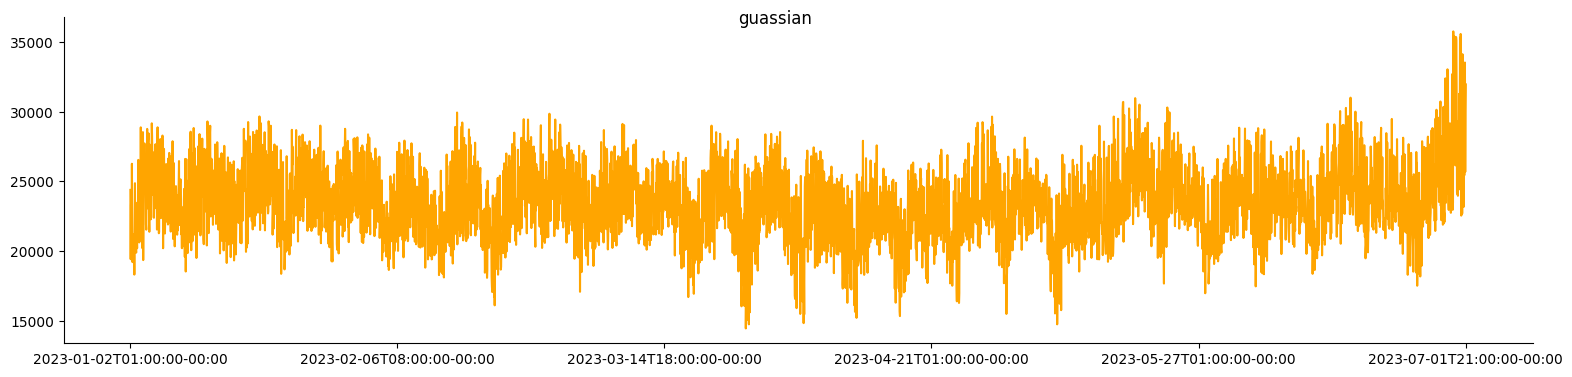

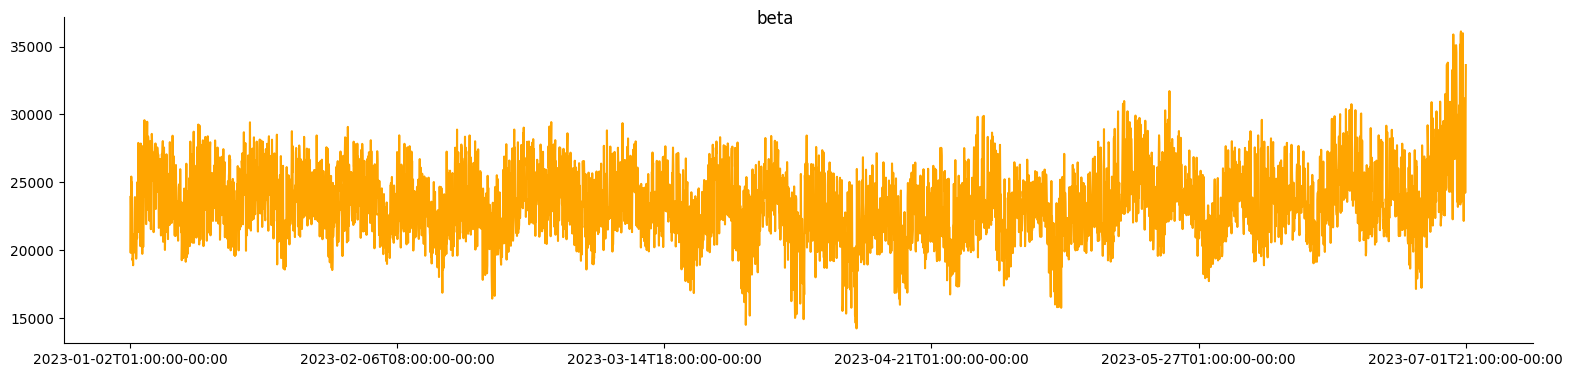

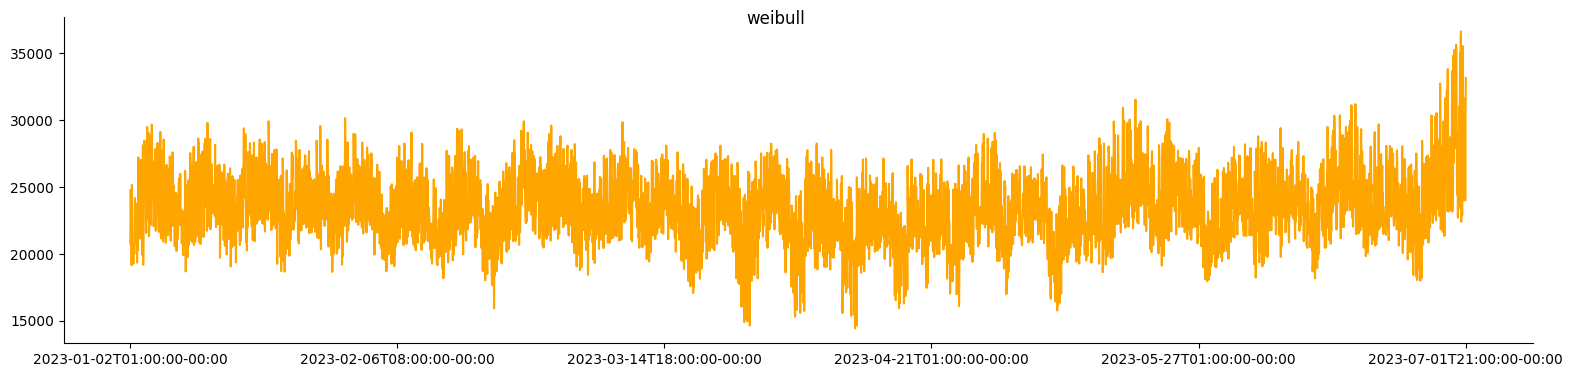

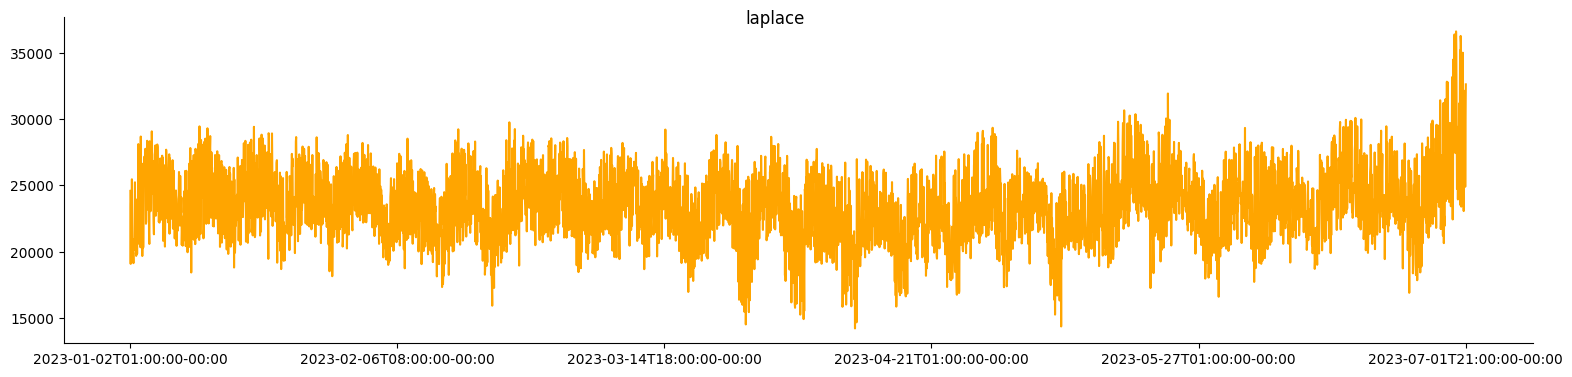

In [289]:
warnings.filterwarnings('ignore')

time_arr, y_DAM, time_arr_val, y_DAM_val, time_arr_test, y_DAM_test = CAISO_forecast()
time_arr, y_truth, time_arr_val, y_truth_val, time_arr_test, y_truth_test = GodMode()


error_range_rate = 0.02
y_guassian = add_gaussian_noise(y_truth, error_range_rate)
plot = sns.relplot(x=time_arr, y=y_guassian, color='orange', kind="line", height=4, aspect=4)
plot.fig.suptitle("guassian")
limit_display(5)

y_beta = add_beta_noise(y_truth, error_range_rate)
plot = sns.relplot(x=time_arr, y=y_beta, color='orange', kind="line", height=4, aspect=4)
plot.fig.suptitle("beta")
limit_display(5)

y_weibull = add_weibull_noise(y_truth, error_range_rate)
plot = sns.relplot(x=time_arr, y=y_weibull, color='orange', kind="line", height=4, aspect=4)
plot.fig.suptitle("weibull")
limit_display(5)

y_laplace = add_laplace_noise(y_truth, error_range_rate)
plot = sns.relplot(x=time_arr, y=y_laplace, color='orange', kind="line", height=4, aspect=4)
plot.fig.suptitle("laplace")
limit_display(5)


In [290]:
warnings.filterwarnings('ignore')

error_range_rate = 1
time_arr, y_DAM, time_arr_val, y_DAM_val, time_arr_test, y_DAM_test = CAISO_forecast()
time_arr, y_truth, time_arr_val, y_truth_val, time_arr_test, y_truth_test = GodMode()
y_guassian = add_gaussian_noise(y_truth, error_range_rate)
y_beta = add_beta_noise(y_truth, error_range_rate)
y_weibull = add_weibull_noise(y_truth, error_range_rate)
y_laplace = add_laplace_noise(y_truth, error_range_rate)

y_guassian_val = add_gaussian_noise(y_truth_val, error_range_rate)
y_beta_val = add_beta_noise(y_truth_val, error_range_rate)
y_weibull_val = add_weibull_noise(y_truth_val, error_range_rate)
y_laplace_val = add_laplace_noise(y_truth_val, error_range_rate)

y_guassian_test = add_gaussian_noise(y_truth_test, error_range_rate)
y_beta_test = add_beta_noise(y_truth_test, error_range_rate)
y_weibull_test = add_weibull_noise(y_truth_test, error_range_rate)
y_laplace_test = add_laplace_noise(y_truth_test, error_range_rate)

X_train = np.concatenate([y_DAM.reshape(-1,1), y_guassian.reshape(-1,1), y_beta.reshape(-1,1), y_weibull.reshape(-1,1), y_laplace.reshape(-1,1), y_truth.reshape(-1,1)], axis=1)
X_val = np.concatenate([y_DAM_val.reshape(-1,1), y_guassian_val.reshape(-1,1), y_beta_val.reshape(-1,1), y_weibull_val.reshape(-1,1), y_laplace_val.reshape(-1,1), y_truth_val.reshape(-1,1)], axis=1)
X_test = np.concatenate([y_DAM_test.reshape(-1,1), y_guassian_test.reshape(-1,1), y_beta_test.reshape(-1,1), y_weibull_test.reshape(-1,1), y_laplace_test.reshape(-1,1), y_truth_test.reshape(-1,1)], axis=1)
N = len(time_arr)
N_val = len(time_arr_val)
N_test = len(time_arr_test)
Y_train = y_truth
Y_val = y_truth_val
Y_test = y_truth_test


In [291]:
from sklearn.neighbors import KNeighborsRegressor
from keras.models import Sequential
from keras.layers import Dense
from sklearn.linear_model import LinearRegression
warnings.filterwarnings('ignore')


def KNN(X_train, Y_train, X_val, Y_val, K):
  """
  K nearest neighbour algorithm
  """
  knn = KNeighborsRegressor(n_neighbors=K)
  knn.fit(X_train, Y_train)
  Y_pred = knn.predict(X_val)
  rmse = np.sqrt(np.mean((Y_pred-Y_val)**2))
  print("KNN Model Parameters:", knn.get_params())
  return rmse, Y_pred



def DNN(X_train, Y_train, X_val, Y_val, epoch):
  model = Sequential()
  model.add(Dense(64, activation='relu', input_shape=(5,)))  
  model.add(Dense(64, activation='relu'))  
  model.add(Dense(1))  
  model.compile(optimizer='adam', loss='mse')
  model.fit(X_train, Y_train, epochs=epoch, batch_size=32, verbose=0)
  Y_pred = model.predict(X_val)
  rmse = np.sqrt(np.mean((Y_pred-Y_val)**2))
  print("DNN Model Parameters:", model.get_config())
  return rmse, Y_pred


def LR(X_train, Y_train, X_val, Y_val):
  regression = LinearRegression()
  regression.fit(X_train, Y_train)
  Y_pred = regression.predict(X_val)
  rmse = np.sqrt(np.mean((Y_pred-Y_val)**2))
  print("Intercept:", regression.intercept_)
  print("Coefficients:", regression.coef_)
  
  return rmse, Y_pred
  

In [292]:
print(X_train.shape)
print(Y_train.shape)

(4367, 6)
(4367,)


In [293]:
rmse_LR, Y_pred_LR = LR(X_train, Y_train, X_val, Y_val)
print(f"LR: {rmse_LR}")

Intercept: -1.0913936421275139e-11
Coefficients: [-1.89121051e-16  1.66533454e-16 -4.85866875e-17 -1.83801708e-17
  2.93684945e-17  1.00000000e+00]
LR: 8.747239945328758e-12


In [294]:
X_train = X_train[:,:-1]
X_val = X_val[:,:-1]
X_test = X_test[:,:-1]

In [295]:
print(X_train.shape)
print(Y_train.shape)

(4367, 5)
(4367,)


In [321]:
DAM_rmse = np.sqrt(np.mean((X_val[:,0]-Y_val)**2))
print(f"baseline rmse: {DAM_rmse}")

baseline rmse: 6507.586144899136


KNN Model Parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}
K=1, KNN: 8445.168323391586
KNN Model Parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}
K=2, KNN: 8395.926928803938
KNN Model Parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 4, 'p': 2, 'weights': 'uniform'}
K=4, KNN: 8327.294535521809
KNN Model Parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 8, 'p': 2, 'weights': 'uniform'}
K=8, KNN: 8323.307512678011
KNN Model Parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 16, 'p': 2, 'weights': 'uniform'}
K=16, KNN: 8333.44190808674
KNN 

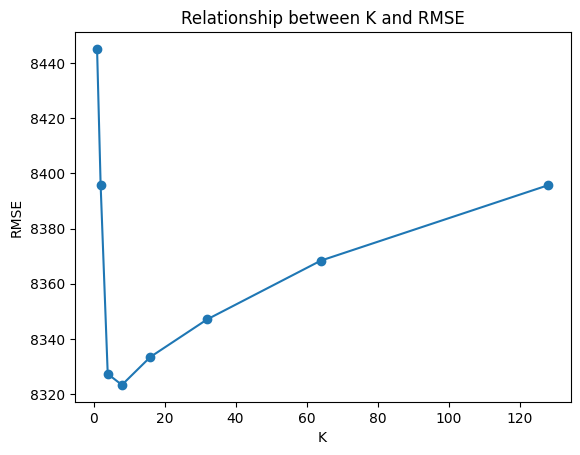

In [296]:
warnings.filterwarnings('ignore')
K_set = []
rmse_set = []
for K in [1, 2, 4, 8, 16, 32, 64, 128]:
  rmse_KNN, Y_pred_KNN = KNN(X_train, Y_train, X_val, Y_val, K)
  K_set.append(K)
  rmse_set.append(rmse_KNN)
  print(f"K={K}, KNN: {rmse_KNN}")
  
plt.plot(K_set, rmse_set, marker='o')
plt.xlabel('K')
plt.ylabel('RMSE')
plt.title('Relationship between K and RMSE')
plt.show()

KNN Model Parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 4, 'p': 2, 'weights': 'uniform'}
K=4, KNN: 8327.294535521809
KNN Model Parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
K=5, KNN: 8304.106160364532
KNN Model Parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 6, 'p': 2, 'weights': 'uniform'}
K=6, KNN: 8305.952975237646
KNN Model Parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}
K=7, KNN: 8329.604238790247
KNN Model Parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 8, 'p': 2, 'weights': 'uniform'}
K=8, KNN: 8323.307512678011
KNN M

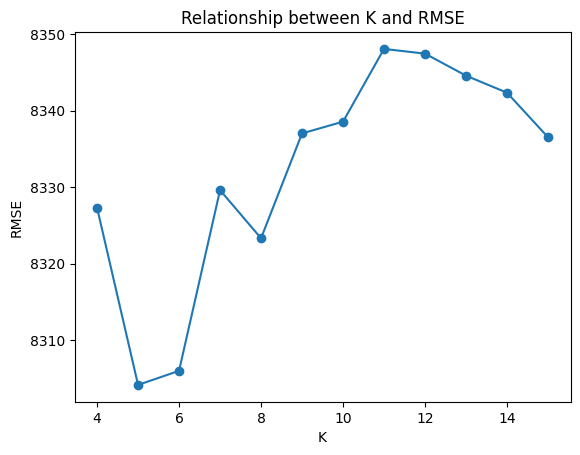

In [309]:
warnings.filterwarnings('ignore')
K_set = []
rmse_set = []
for K in range(4,16):
  rmse_KNN, Y_pred_KNN = KNN(X_train, Y_train, X_val, Y_val, K)
  K_set.append(K)
  rmse_set.append(rmse_KNN)
  print(f"K={K}, KNN: {rmse_KNN}")
  
plt.plot(K_set, rmse_set, marker='o')
plt.xlabel('K')
plt.ylabel('RMSE')
plt.title('Relationship between K and RMSE')
plt.show()

24/24 [==============================] - 0s 355us/step
DNN Model Parameters: {'name': 'sequential_154', 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 5), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'dense_462_input'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_462', 'trainable': True, 'dtype': 'float32', 'batch_input_shape': (None, 5), 'units': 64, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 5)}}, {'module': '

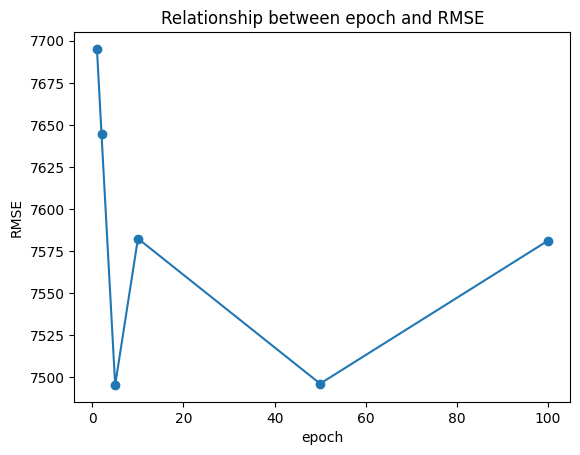

In [298]:
epoch_set = []
rmse_set = []
for epoch in [1, 2, 5, 10, 50, 100]:
  rmse_DNN, Y_pred_DNN = DNN(X_train, Y_train, X_val, Y_val, epoch)
  print(f"epoch:{epoch}, DNN: {rmse_DNN}")
  epoch_set.append(epoch)
  rmse_set.append(rmse_DNN)
  
plt.plot(epoch_set, rmse_set, marker='o')
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.title('Relationship between epoch and RMSE')
plt.show()

24/24 [==============================] - 0s 380us/step
DNN Model Parameters: {'name': 'sequential_253', 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 5), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'dense_759_input'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_759', 'trainable': True, 'dtype': 'float32', 'batch_input_shape': (None, 5), 'units': 64, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 5)}}, {'module': '

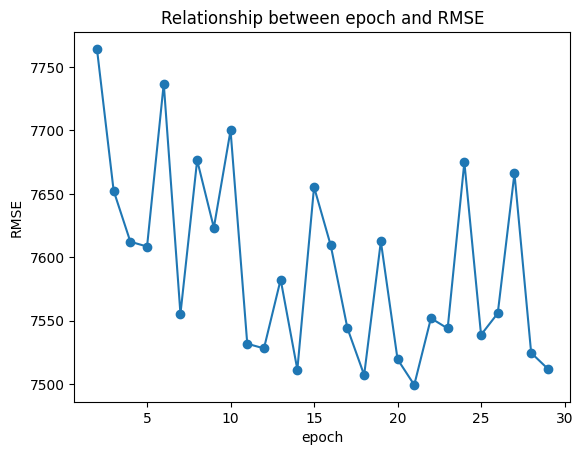

min_epoch=21, min_rmse=7499.365041317258


In [313]:
epoch_set = []
rmse_set = []
min_epoch, min_rmse = 0, 1e7
for epoch in range(2,30):
  rmse_DNN, Y_pred_DNN = DNN(X_train, Y_train, X_val, Y_val, epoch)
  print(f"epoch:{epoch}, DNN: {rmse_DNN}")
  epoch_set.append(epoch)
  rmse_set.append(rmse_DNN)
  if min_rmse>rmse_DNN:
    min_epoch, min_rmse = epoch, rmse_DNN
  
plt.plot(epoch_set, rmse_set, marker='o')
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.title('Relationship between epoch and RMSE')
plt.show()
print(f'min_epoch={min_epoch}, min_rmse={min_rmse}')

In [322]:
rmse_LR, Y_pred_LR = LR(X_train, Y_train, X_val, Y_val)
print(f"LR: {rmse_LR}")

Intercept: 17397.448426569677
Coefficients: [0.24249123 0.00631843 0.00509287 0.00558023 0.00482242]
LR: 6895.668299436404


In [315]:
rmse_equal = np.sqrt(np.mean((np.average(X_val, axis=1)-Y_val)**2))
print(rmse_equal)

17729.675905794487


Intercept: 17397.448426569677
Coefficients: [0.24249123 0.00631843 0.00509287 0.00558023 0.00482242]
-4746.754596314167
1540.7635085446127
-15192.94085392678


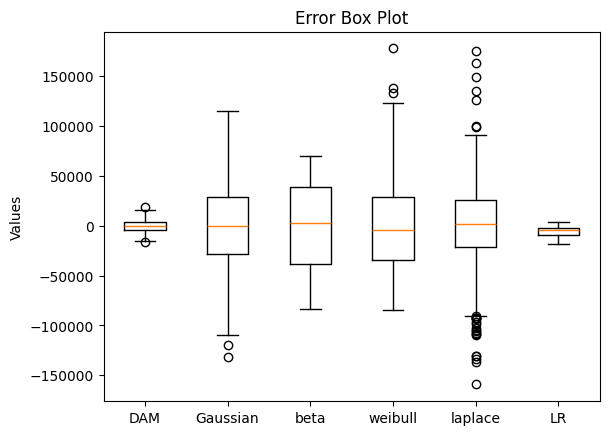

In [318]:
_, Y_pred_test = LR(X_train, Y_train, X_test, Y_test)
Error = Y_pred_test - Y_test

# median, 97.5 percentile, 2.5 percentile
median = np.median(Error)
percentile_975 = np.percentile(Error, 97.5)
percentile_25 = np.percentile(Error, 2.5)
print(median)
print(percentile_975)
print(percentile_25)

# error box plot Error, F1,.. F5, ensemble
data = np.concatenate([X_test-Y_test[:,np.newaxis], Error.reshape((Error.shape[0],1))], axis=1)
fig, ax = plt.subplots()
ax.boxplot(data)
ax.set_xticklabels(['DAM', 'Gaussian', 'beta', 'weibull', 'laplace', 'LR'])
ax.set_ylabel('Values')
ax.set_title('Error Box Plot')
plt.show()

In [320]:
error = [
  np.sqrt(np.mean((X_test[:,0]-Y_test)**2)),\
  np.sqrt(np.mean((X_test[:,1]-Y_test)**2)),\
  np.sqrt(np.mean((X_test[:,2]-Y_test)**2)),\
  np.sqrt(np.mean((X_test[:,3]-Y_test)**2)),\
  np.sqrt(np.mean((X_test[:,4]-Y_test)**2)),\
  np.sqrt(np.mean((Error)**2))
  ]
print(error)

[6274.091745498951, 43181.63390728544, 44092.0, 44092.0, 44092.0, 7089.3055954979245]


In [308]:
Previous = X_train[:-1]-Y_train[:-1,np.newaxis]
Error_array = X_train[1:] - Previous
print(X_train.shape)
print(Error_array.shape)

(4367, 5)
(4366, 5)
